<br>
<h1 style="font-family:sans-serif; text-align:center"> 
<!--     <span style='color: pink'> Twitter analysis of </span> -->
    <span style='color: white; font-size:50%; text-shadow: 0px 0px 15px black'> Twitter analysis of </span>
<!--     <span style='color:#00acee'> Twitter analysis of </span> -->
<!--     <span style="-webkit-text-stroke"> Twitter analysis of</span> -->
<!--     <span class="hr3" style='color:#e40843; letter-spacing: 4px; font-size:105%'> Canada</span> -->
    <span class="hr3" style='color:#e40843; font-size:60%; text-shadow: 0px 0px 30px pink'>Canada </span> <span class="hr3" style='color:gray; font-size:50%; text-shadow: 0px 0px 30px pink'>response to Covid-19</span><br>
</h1>

# Sentiment Analysis

The aim of this notebook is to analyze the retrieved tweets obtained using *snscrape*, from February 1st to April 30th of 2020, from Government of Canada official Twitter accounts using descriptive statistics based in counts of words, word clouds, tokens, polarity and subjectivity scores, time series, hypothesis testing, ETS decomposition, and volume of tweets of actions as replies, retweets, likes and quote.

_Authors: Leo Cuspinera ([cuspime](https://github.com/cuspime)) and Victor Cuspinera ([vcuspinera](https://github.com/vcuspinera))_

## Import libraries

In [634]:
# General libraries
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime, timedelta, date

# To plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# plt.rcParams["figure.figsize"] = (18,6)
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()

# Preprocess libraries
import re
import spacy
import string
import en_core_web_sm
nlp = en_core_web_sm.load()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# WordCloud
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For Sentiment Analysis
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from scipy.stats import ttest_ind

# For Timeseries:
pd.plotting.register_matplotlib_converters()
from statsmodels.tsa.seasonal import seasonal_decompose

In [635]:
# Parameters
START = time.time()
my_folder = "../tweets/"

## Open `json` files with all tweets
You just need to run this process once time, it opens the fragmented 10 files of tweets sentiment obtained from the Python script `tweets_sentiment.py` and gather them in one only file. If you already run this section before, just jump to the next section __*Open tweets_db_sentiment.json file*__

In [636]:
%%time

# Open `json` files of tweets with spaCy sentiment
df = pd.DataFrame()
for i in range(0,10):
    try:
        df_sub = pd.read_json(my_folder + 'tweets_sentiment_' + str(i) + '.json')
        df = pd.concat([df, df_sub])
    except:
        next

df.reset_index(drop=True, inplace=True)

CPU times: user 14.3 s, sys: 3.47 s, total: 17.7 s
Wall time: 19.8 s


In [637]:
# show the data frame
df.tail(3)

account                date  replyCount  retweetCount  \
779667  @JustinTrudeau 2020-04-30 00:00:27           1             0   
779668  @JustinTrudeau 2020-04-30 00:00:19           1             0   
779669  @JustinTrudeau 2020-04-30 00:00:08           0             0   

        likeCount  quoteCount lang         sourceLabel      username  \
779667          2           0   en  Twitter for iPhone  SRodrigues52   
779668          0           0   en  Twitter for iPhone       pffoote   
779669          0           0   en     Twitter Web App  DavidCBarron   

        followersCount  friendsCount                location  \
779667             216           417              London, On   
779668             364          1535  St. John's, NL, Canada   
779669             230           332        Brampton Ontario   

                                                    tweet         day  \
779667                     @justintrudeau quit your job 🧐  2020-04-30   
779668  @rcaf_arc @cfsnowbirds @canadianforces @cfoper...  2020-04-30   
779669  @cbcnews @ctvnews @justintrudeau @celliottabil...  2020-04-30   

       announcement  polarity  subjectivity  
779667        after  0.000000      0.000000  
779668        after  0.392857      0.517857  
779669        after -1.000000      1.000000

In [638]:
# Save the final version of the tweet's database
df.to_json(my_folder + 'tweets_db_sentiment.json')

## Open `tweets_db_sentiment.json` file

In [639]:
%%time

# Open `json` file with all tweets preprocessed and with sentiment scores
df = pd.read_json(my_folder + 'tweets_db_sentiment.json')

CPU times: user 15.4 s, sys: 2.91 s, total: 18.3 s
Wall time: 19.2 s


## Analysis of all tweets
In this section we work with wordcloud and sentiment analysis of all tweets.

### Wordcloud

In [640]:
# data and mask
allwords = ' '.join(df.tweet.values.tolist())
mask = np.array(Image.open('../img/Canadian_Flag.jpg'))

In [641]:
# get wordcloud
wcloud = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, 
                   background_color='white', max_words=400, collocations=False, 
                   mode='RGBA', mask=mask).generate(allwords)

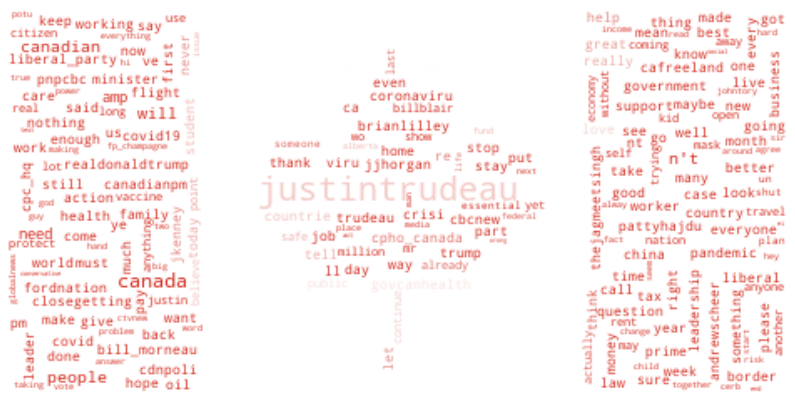

In [642]:
# plot
plt.figure(figsize=(14,8))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.imshow(wcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../img/canada_word_cloud.jpg", format="jpg")

> In the wordcloud we find that the most used word in the tweets is `justintrudeau`, followed by `canada`. Other words highly used in tweets as `pandemic`,`cafreeland`, `canadian`, `realdonaldtrump`, `covid19`, `pandemic`, `china`, among others.

### Repetition of tokens

In [643]:
df_weights = pd.DataFrame.from_dict(wcloud.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'weight'})

In [644]:
pd.DataFrame(wcloud.layout_)[1]
df_weights.head()

word    weight
0  justintrudeau  1.000000
1         canada  0.155257
2           will  0.111556
3         people  0.109005
4            n't  0.104885

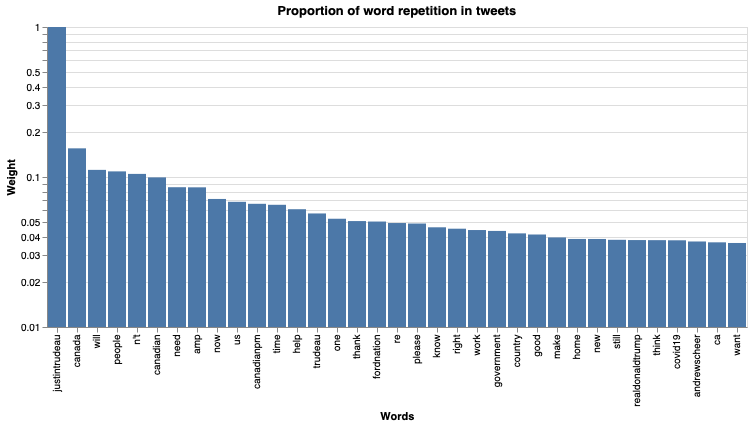

In [645]:
# plot
alt.Chart(df_weights[:35]).mark_bar().encode(
    x=alt.X('word', sort=df_weights.word.to_list(), title="Words"),
    y=alt.Y('weight', title="Weight", scale=alt.Scale(type='log')),
    tooltip=['word', 'weight']
).properties(
    title="Proportion of word repetition in tweets"
)

> In the previous plot we identify the words with higher proportion of repetitions, considering `justintrudeau` as the word more repeated in tweets. These more repeated words coincide with the biggest words in the previous word cloud.

## Analysis comparing tweets before and after Trudeau's announcement
In this section we work with wordcloud and sentiment analysis comparing results of tweets published before Trudeau's announcement, with tweets published after the announcement.

### Wordclouds

In [646]:
allwords_before = ' '.join(df[df.announcement == "before"].tweet.values.tolist())
allwords_after = ' '.join(df[df.announcement == "after"].tweet.values.tolist())

In [647]:
# get wordcloud
wcloud_before = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=400, collocations=False, mode='RGBA', mask=mask).generate(allwords_before)
wcloud_after = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=400, collocations=False, mode='RGBA', mask=mask).generate(allwords_after)

Text(0.5, 1.0, "Wordcloud of tweets before Trudeau's announcement\n")

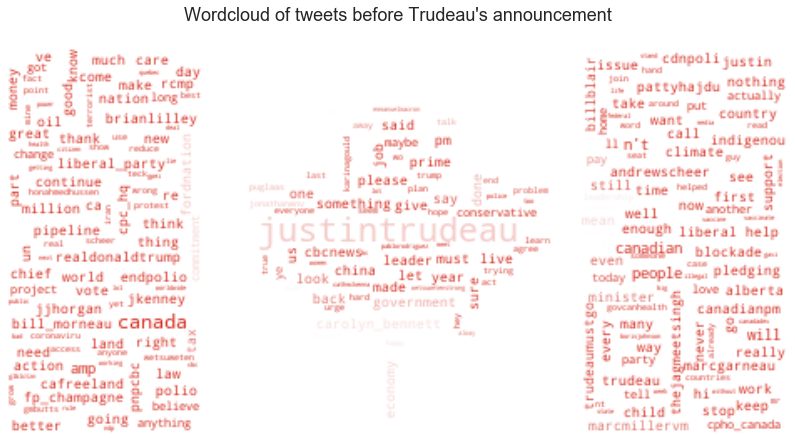

In [648]:
# Wordcloud - before Trudeau's announcement
plt.figure(figsize=(14,8))
plt.imshow(wcloud_before.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of tweets before Trudeau's announcement\n", fontsize=18)

Text(0.5, 1.0, "Wordcloud of tweets after Trudeau's announcement\n")

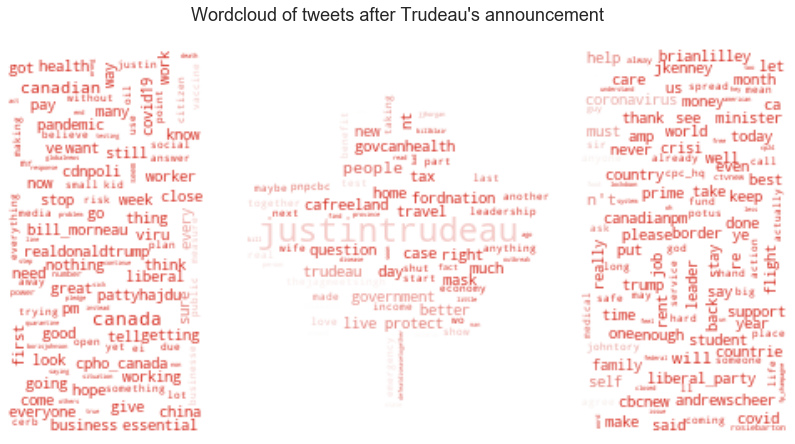

In [649]:
# Wordcloud - after Trudeau's announcement
plt.figure(figsize=(14,8))
plt.imshow(wcloud_after.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of tweets after Trudeau's announcement\n", fontsize=18)

> When comparing the wordcloud of tweets published before Trudeau's announcement on March 27th 2020, with the wordcloud of tweets published after the announcement, it looks that the words more used are the same in both graphs.

### Repetition of tokens from tweets before and after Trudeau's announcement

In [650]:
df_w_before = pd.DataFrame.from_dict(wcloud_before.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'w_before'})
df_w_after = pd.DataFrame.from_dict(wcloud_after.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'w_after'})

In [651]:
df_w = pd.merge(df_w_before, df_w_after, on="word")
df_w.head(10)

word  w_before   w_after
0  justintrudeau  1.000000  1.000000
1         canada  0.179888  0.145759
2            n't  0.098642  0.107293
3           will  0.098597  0.116554
4       canadian  0.093130  0.101841
5            amp  0.089883  0.083584
6         people  0.083359  0.118895
7           need  0.071397  0.090913
8        trudeau  0.068229  0.052871
9   andrewscheer  0.062982  0.027205

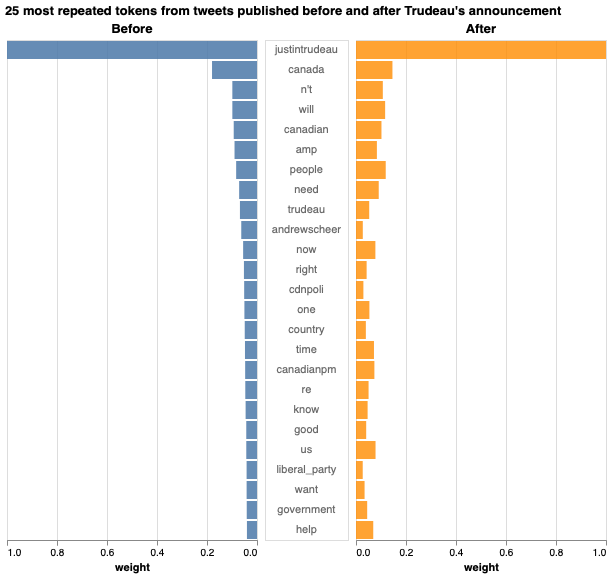

In [652]:
#plot
base = alt.Chart(df_w[:25]).properties(width=250)
my_order = df_w.word.to_list()

left = base.encode(
    y=alt.Y('word', axis=None, sort=my_order),
    x=alt.X('w_before', title='weight',
    scale=alt.Scale(reverse=True)),
    tooltip=['word', 'w_before']
).mark_bar(opacity=0.85).properties(title="Before")

middle = base.encode(
    y=alt.Y('word', axis=None, sort=my_order),
    text=alt.Text('word'),
).mark_text(color='dimgray').properties(width=83)

right = base.encode(
    y=alt.Y('word:O', axis=None, sort=my_order),
    x=alt.X('w_after', title='weight'),
    tooltip=['word', 'w_after']
).mark_bar(color='darkorange', opacity=0.8).properties(title="After")

alt.concat(left, middle, right, spacing=5)\
    .properties(title="25 most repeated tokens from tweets published before and after Trudeau's announcement")

> In general, it looks that each word have similar weights in the tweets published before and after Trudeau's announcement. Among the 25 most-repeated words, `border` have higher weights before the annoucement; in contrast it looks that `help`, `covid` and `help` have higher weights after the annoucement.

### Sentiment anlysis by tweets - general
Exploring sentiment analysis with [TextBlob](https://textblob.readthedocs.io/en/dev/):  
- `polarity` score is a float within the range [-1.0, 1.0]
- `subjectivity` is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective

In [653]:
# polarity data
df['bin_polarity'] = pd.cut(df.polarity, bins=25)
df_bin_polarity = pd.DataFrame(df.groupby(['bin_polarity', 'announcement'])['tweet'].count()).reset_index()
df_bin_polarity.bin_polarity = [np.mean([i.left, i.right]) for i in df_bin_polarity.bin_polarity]

# subjectivity data
df['bin_subjectivity'] = pd.cut(df.subjectivity, bins=25)
df_bin_subjectivity = pd.DataFrame(df.groupby(['bin_subjectivity', 'announcement'])['tweet'].count()).reset_index()
df_bin_subjectivity.bin_subjectivity = [np.mean([i.left, i.right]) for i in df_bin_subjectivity.bin_subjectivity]

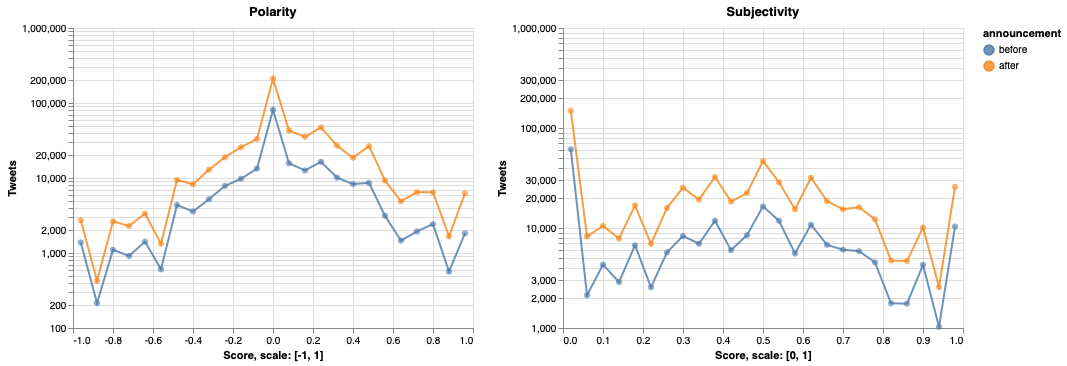

In [654]:
# polarity plot
polar = alt.Chart(df_bin_polarity).encode(
    alt.X("bin_polarity", title="Score, scale: [-1, 1]",scale=alt.Scale(domain=(-1, 1))),
    alt.Y("tweet", scale=alt.Scale(type='log'), title="Tweets"),
    alt.Color('announcement', sort=['before', 'after'])
).properties(title="Polarity")

polar_line=polar.mark_line(clip=True, opacity=0.8)
polar_point=polar.mark_circle(opacity=0.6, size=40)

# subjectivity plot
subject = alt.Chart(df_bin_subjectivity).mark_line(clip=True, opacity=0.8).encode(
    alt.X("bin_subjectivity", title="Score, scale: [0, 1]", scale=alt.Scale(domain=(0, 1))),
    alt.Y("tweet", scale=alt.Scale(type='log'), title="Tweets"),
    alt.Color('announcement', sort=['before', 'after'])
).properties(title="Subjectivity")

subject_line=subject.mark_line(clip=True, opacity=0.8)
subject_point=subject.mark_circle(opacity=0.6, size=40)

(polar_line+polar_point) | (subject_line+subject_point)

> In the previous plots we observe that the information from tweets before and after the announcement have very similar Polarity and Subjectivity curves.  
>
> In the Polarity plot, the largest number of tweets are neutral -around zero-. Beyond this, when comparing negative with positives tweets, overall we can see more positive than negative tweets, for both group of tweets (before and after the announcement). Also, it looks that users shared more tweets after the announcement than before.
>
> In the other hand, in the Subjectivity plot, the higer number of tweets were zero, which means a high number of tweets were completly objective. The second group with higher subjectivity score belong to tweets scored as 0.5 which is the half way between objective and subjective. Finally the third group of tweets with high score have a 1.0 value which means they were completly subjective. Similar to the Polarity plot, there were more tweets after the announcement than before it.
>
> Until this point, we haven't find any difference between tweets from users published before and after Trudeau's announcement.

### Sentiment anlysis by tweets - per account

#### Polarity and subjectivity per account

In [655]:
# polarity data
df_bin_polarity2 = pd.DataFrame(df.groupby(['bin_polarity', 'account', 'announcement'])['tweet'].count()).reset_index()
df_bin_polarity2.bin_polarity = [np.mean([i.left, i.right]) for i in df_bin_polarity2.bin_polarity]

# subjectivity data
df_bin_subjectivity2 = pd.DataFrame(df.groupby(['bin_subjectivity', 'account', 'announcement'])['tweet'].count()).reset_index()
df_bin_subjectivity2.bin_subjectivity = [np.mean([i.left, i.right]) for i in df_bin_subjectivity2.bin_subjectivity]

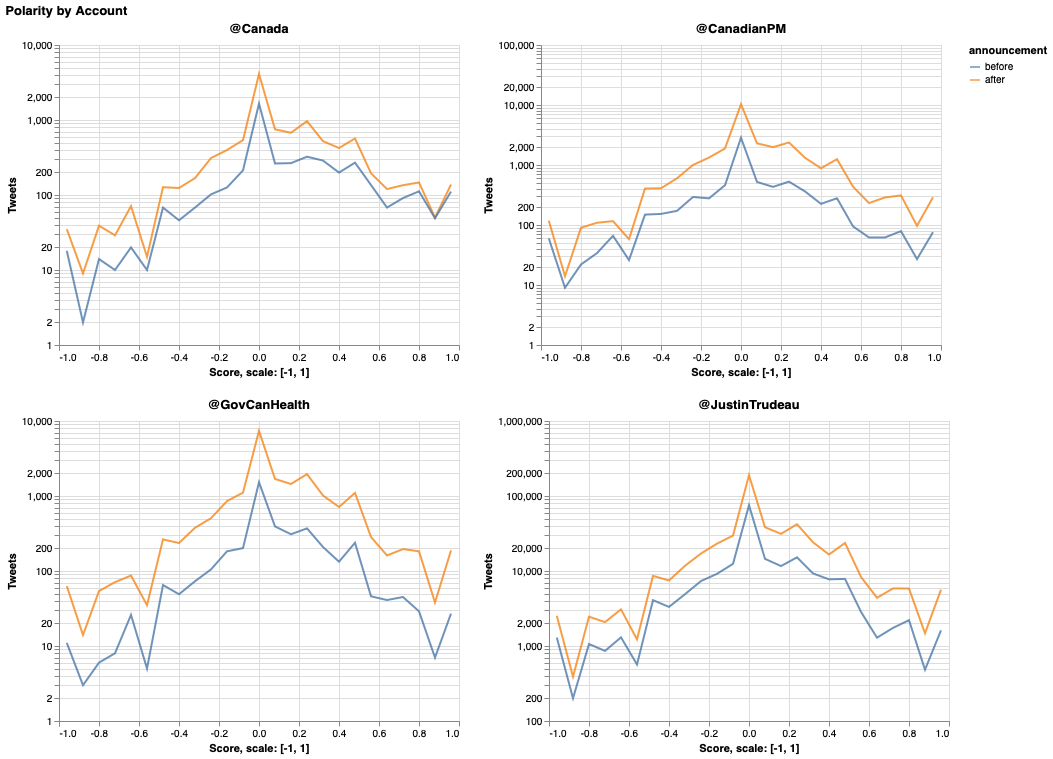

In [656]:
# polarity plots by account
plots = dict()
accounts= ['@CanadianPM', '@Canada', '@GovCanHealth', '@JustinTrudeau']
for i in accounts:#df_bin_polarity2.account.unique():
    plots[i] = alt.Chart(df_bin_polarity2[df_bin_polarity2.account == i]).mark_line(clip=True, opacity=0.8).encode(
        alt.X("bin_polarity:Q", title="Score, scale: [-1, 1]", scale=alt.Scale(domain=(-1, 1))),
        alt.Y("tweet:Q",  title="Tweets", scale=alt.Scale(type='log')),
        alt.Color('announcement', sort=['before', 'after']),
    ).properties(title=i)

((plots['@Canada']  | plots['@CanadianPM']) & \
    ((plots['@GovCanHealth'] | plots['@JustinTrudeau'])))\
    .properties(title="Polarity by Account")

The previous polarity plots by account are very similar to the general polarity plot from the previous section. In all cases both groups (tweets before and after the announcement) have similar curves for all accounts. However, something interesting is that for the GovCanHealth account tweets published before the announcement are higher than tweets after it.

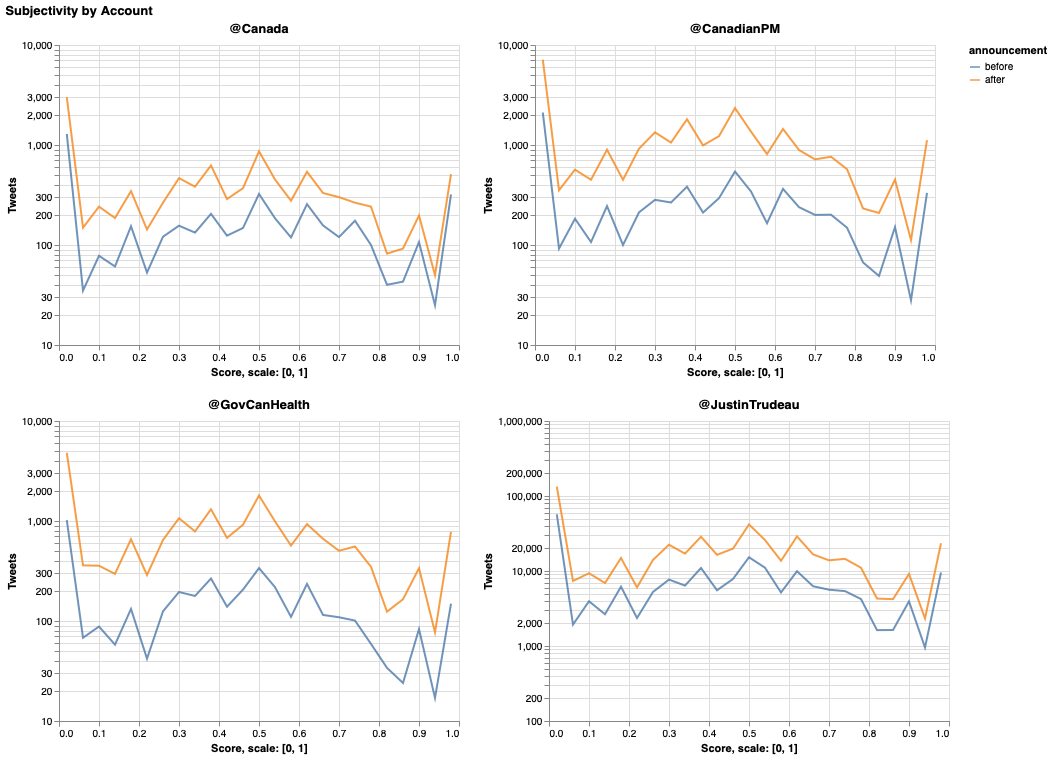

In [657]:
# subjectivity plots by account
plots = dict()
for i in df_bin_subjectivity2.account.unique():
    plots[i] = alt.Chart(df_bin_subjectivity2[df_bin_subjectivity2.account==i]).mark_line(clip=True, opacity=0.8).encode(
        alt.X("bin_subjectivity", title="Score, scale: [0, 1]", scale=alt.Scale(domain=(0, 1))),
        alt.Y("tweet", scale=alt.Scale(type='log'), title="Tweets"),
        alt.Color('announcement', sort=['before', 'after']),
    ).properties(title=i)

((plots['@Canada'] | plots['@CanadianPM']) & \
    (plots['@GovCanHealth'] | plots['@JustinTrudeau']))\
    .properties(title="Subjectivity by Account")

For subjectivity plots, also both groups have similar curves for each account, with highest value in 0.0, followed by 0.5 score.

#### Generating samples

In this section, we generate 10 thousand normal samples using the Mean and Standard deviation for each Government of Canada Twitter's account (@Canada, @JustinTrudeau, @CanadianPM, @GovCanHealth)

In [658]:
# Stats
df_stats = df.groupby(['account', 'announcement'])['polarity', 'subjectivity'].agg([pd.Series.count, np.mean, np.std]).reset_index()
df_stats

account announcement  polarity                     subjectivity  \
                                   count      mean       std        count   
0         @Canada        after   10672.0  0.103294  0.287021      10672.0   
1         @Canada       before    4528.0  0.151103  0.323498       4528.0   
2     @CanadianPM        after   28222.0  0.076089  0.278173      28222.0   
3     @CanadianPM       before    7320.0  0.050924  0.294752       7320.0   
4   @GovCanHealth        after   20029.0  0.091168  0.268650      20029.0   
5   @GovCanHealth       before    4109.0  0.087362  0.260788       4109.0   
6  @JustinTrudeau        after  506477.0  0.073669  0.289897     506477.0   
7  @JustinTrudeau       before  198313.0  0.055082  0.287751     198313.0   

                       
       mean       std  
0  0.365074  0.306455  
1  0.392588  0.325602  
2  0.370699  0.292176  
3  0.360776  0.306254  
4  0.373065  0.288623  
5  0.369709  0.288901  
6  0.378206  0.302360  
7  0.370164  0.307836

#### Polarity

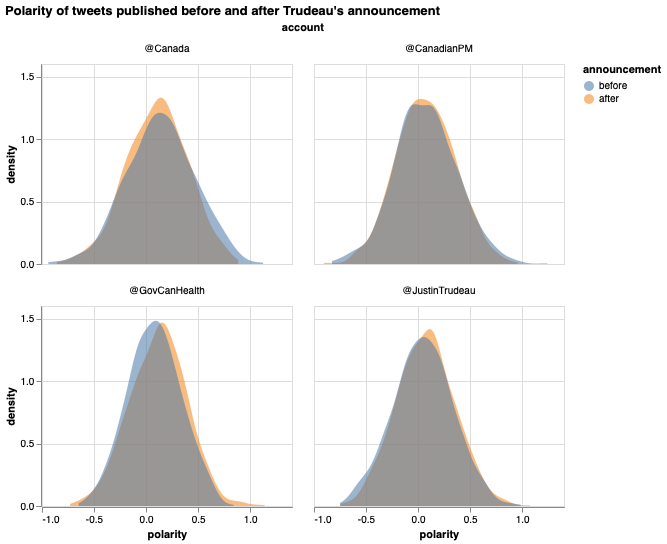

In [659]:
# Select stats for Polarity
df_stats_polar = df_stats[['polarity', 'account', 'announcement']]

# Get samples
my_dict = {}
num = 0
for i in df_stats_polar.account.unique():
    for j in df_stats_polar.announcement.unique():
        my_df = df_stats_polar[(df_stats_polar.account == i) & 
                               (df_stats_polar.announcement == j)].polarity[['mean', 'std']]
        mu = float(my_df['mean'])
        sd = float(my_df['std'])
        my_dict[num] = {
            "account": i,
            "announcement": j,
            "mu": mu,
            "sd": sd,
            "samples": np.random.normal(mu, sd, 1_000)
        }
        num += 1

df_polar_samples = pd.DataFrame()
for i in my_dict:
    df_polar_samples = pd.concat([df_polar_samples, pd.DataFrame(my_dict[i])])

df_polar_samples.reset_index(drop=True, inplace=True)

# Plot
alt.Chart(df_polar_samples, width=250, height=200).transform_density(
    'samples',
    groupby=['account', 'announcement'],
    as_=['samples', 'density']
).mark_area(opacity=0.55).encode(
    x=alt.X("samples:Q", title="polarity"),
    y='density:Q',
    color=alt.Color("announcement", sort=['before', 'after'])
).facet(
    "account",
    columns=2
).properties(
    title="Polarity of tweets published before and after Trudeau's announcement"
)

#### Subjectivity

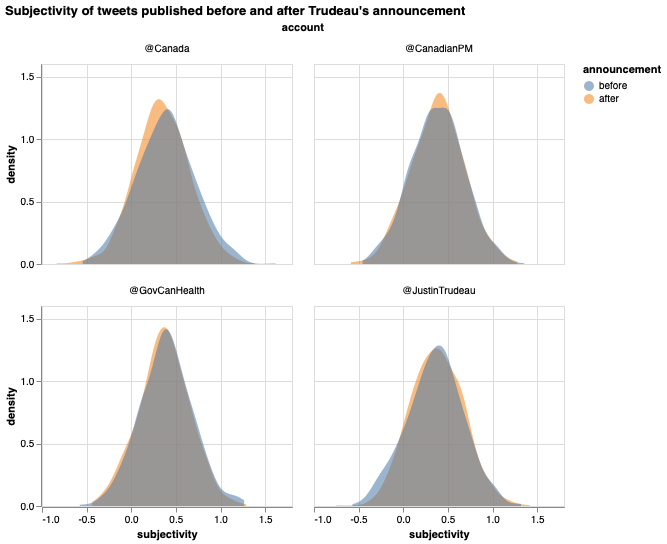

In [660]:
# Select stats for Subjectivity
df_stats_subj = df_stats[['subjectivity', 'account', 'announcement']]

# Get samples
my_dict = {}
num = 0
for i in df_stats_subj.account.unique():
    for j in df_stats_subj.announcement.unique():
        my_df = df_stats_subj[(df_stats_subj.account == i) & (df_stats_subj.announcement == j)].subjectivity[['mean', 'std']]
        mu = float(my_df['mean'])
        sd = float(my_df['std'])
        my_dict[num] = {
            "account": i,
            "announcement": j,
            "mu": mu,
            "sd": sd,
            "samples": np.random.normal(mu, sd, 1_000)
        }
        num += 1

df_subj_samples = pd.DataFrame()
for i in my_dict:
    df_subj_samples = pd.concat([df_subj_samples, pd.DataFrame(my_dict[i])])

df_subj_samples.reset_index(drop=True, inplace=True)

# Plot
alt.Chart(df_subj_samples, width=250, height=200).transform_density(
    'samples',
    groupby=['account', 'announcement'],
    as_=['samples', 'density']
).mark_area(opacity=0.55).encode(
    x=alt.X("samples:Q", title="subjectivity"),
    y='density:Q',
    color=alt.Color("announcement", sort=['before', 'after'])
).facet(
    "account",
    columns=2
).properties(
    title="Subjectivity of tweets published before and after Trudeau's announcement"
)

> When generating samples with the mean and standar deviation of the polarity and subjectivity, it looks that there is not any difference in sentiment of tweets before and after Trudeau's announcement, in any of the governments accounts.
>
> Just to be sure that, we made some hypotesis testing to know if there is some statistical difference in sentiment of tweets before vs after the annoucement.

### Sentiment analysis for tweets that have an opinion
As we see before, [TextBlob](https://textblob.readthedocs.io/en/dev/)'s `subjectivity` is a float within the range [0.0, 1.0], that in our project 0.0 is a completely objective tweet, and 1.0 is very subjective that only reflects the opinion of the user.

In this subsection we drop tweets with $subjectivity=0.0$, and keep only messages with $subjectivity>0.0$ to analyze only tweets that have an opinion.

In [661]:
df.subjectivity.describe()

count    779670.000000
mean          0.375452
std           0.303250
min           0.000000
25%           0.000000
50%           0.400000
75%           0.600000
max           1.000000
Name: subjectivity, dtype: float64

At the moment we have 779670 tweets in totalt but here are 208789 that seem to not have an opinion. In this subsection we will remain with the remaining 570881 tweets.


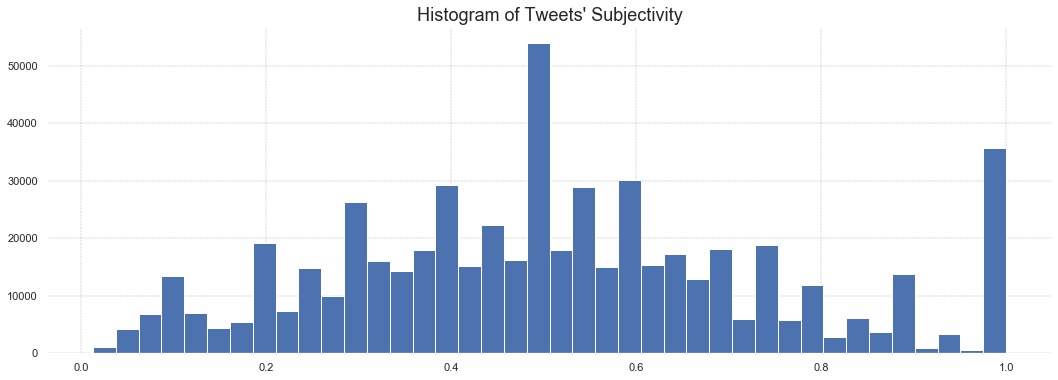

In [662]:
# People with an even so slight opinion. Just ask it's diff to 0!
op = df[df.subjectivity!=0]
op.subjectivity.hist(bins=40).set_facecolor("white");
plt.grid(color='gray', linestyle='-.', linewidth=0.3)
plt.title("Histogram of Tweets' Subjectivity", size=18)
print('At the moment we have {} tweets in totalt but here are {} that seem to not have an opinion. In this subsection we will remain with the remaining {} tweets.'.format(
    df.shape[0],
    df.shape[0] - op.shape[0], 
    op.shape[0]
))

<Figure size 1152x576 with 0 Axes>

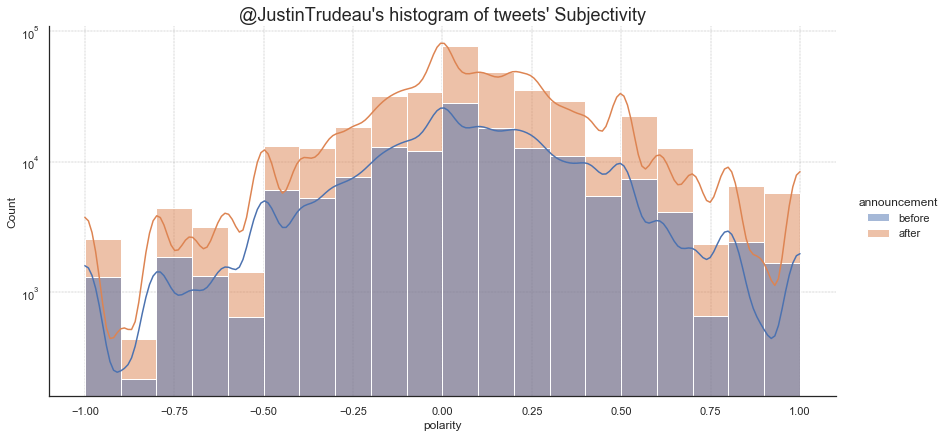

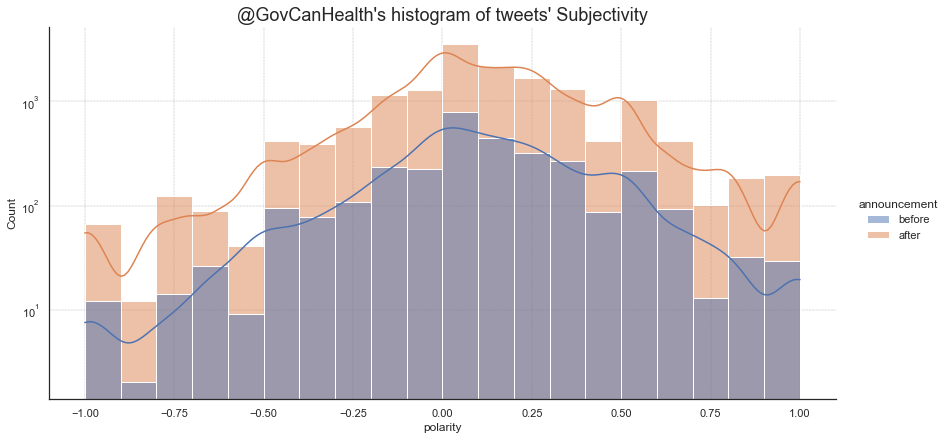

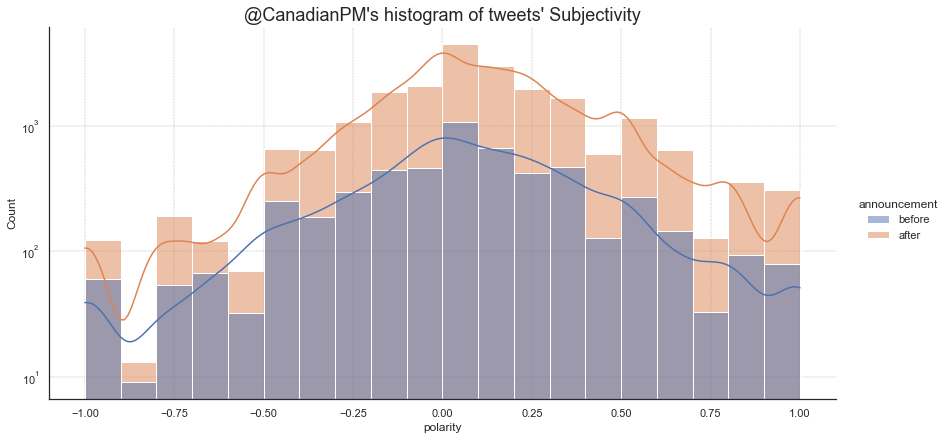

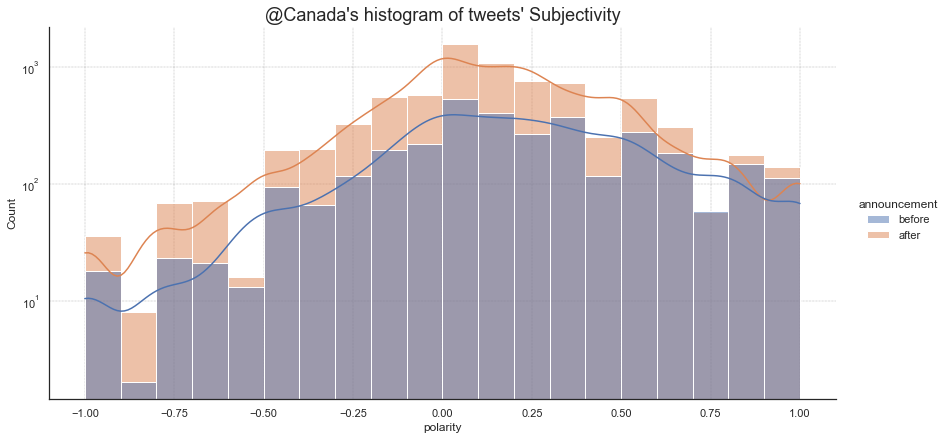

In [663]:
plt.figure(figsize=(16,8));
for acc in op.account.unique()[::-1].tolist():
    sns.set_style("white")
    sns.displot(data=op[op.account==acc], x='polarity', hue='announcement',
            bins=20,log_scale=(False, True), kde=True, alpha=.5, height=6, aspect=2),
    plt.title(acc + "'s histogram of tweets' Subjectivity", size=18)
    plt.grid(color='gray', linestyle='-.', linewidth=0.3);

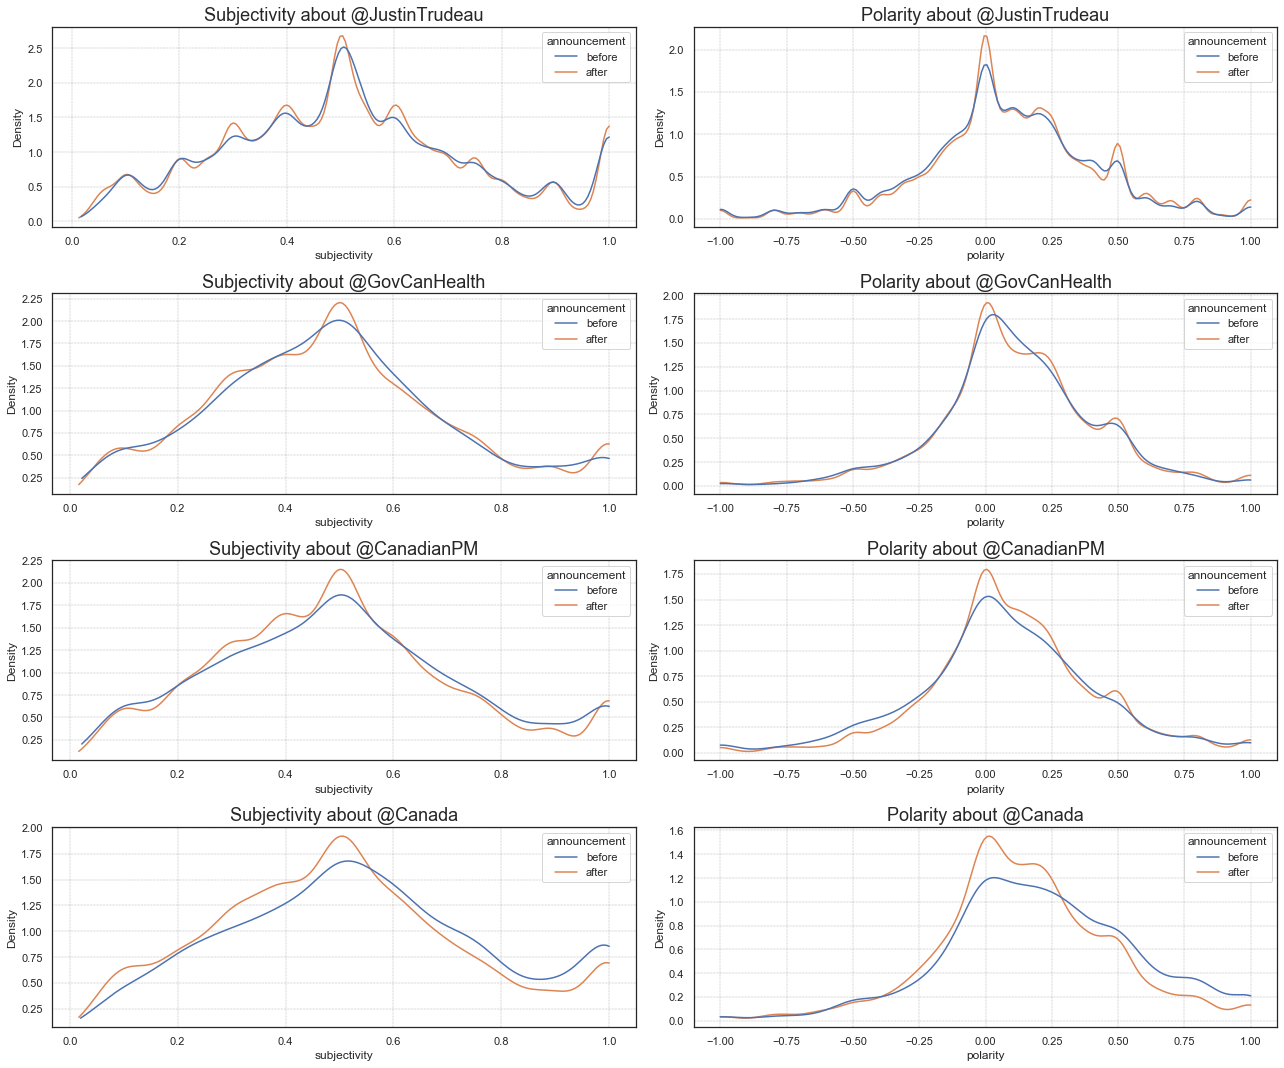

<Figure size 1152x576 with 0 Axes>

In [664]:
fig,ax = plt.subplots(4,2, sharex=False)
fig.set_figheight(15)
plt.figure(figsize=(16,8));
for i, acc in enumerate(op.account.unique()[::-1].tolist()):
    
    # Subjectivity
    sns.kdeplot(data=op[op.account==acc], x='subjectivity', hue='announcement', common_norm=False,
             alpha=.5, ax=ax[i,0], cut=0, bw_adjust=1);
    ax[i,0].set_title('Subjectivity about '+acc, size=18)
    ax[i,0].set_facecolor('white');
    ax[i,0].grid(color='gray', linestyle='-.', linewidth=0.3);
    
    # Polarity
    sns.kdeplot(data=op[op.account==acc], x='polarity', hue='announcement', common_norm=False,
             alpha=.5, ax=ax[i,1], cut=0, bw_adjust=1);
    ax[i,1].set_title('Polarity about '+acc, size=18)
    ax[i,1].set_facecolor('white')
    ax[i,1].grid(color='gray', linestyle='-.', linewidth=0.3);
    
fig.tight_layout()

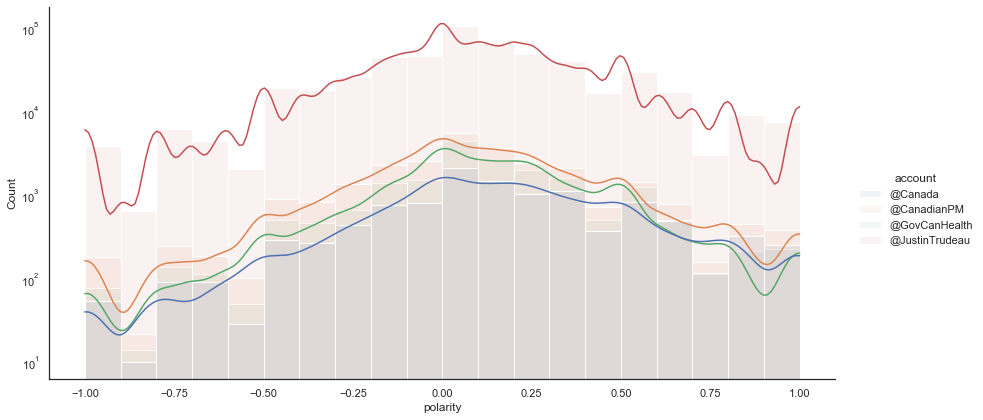

In [665]:
sns.displot(data=op, x='polarity', hue='account', 
            bins=20,log_scale=(False, True), kde=True, alpha=.08, height=6, aspect=2);

### Polarity vs. Subjectivity
In this section we compare the distribution of number of tweets by `polarity` and `subjectivity` bins, using only tweets that have an opinion.

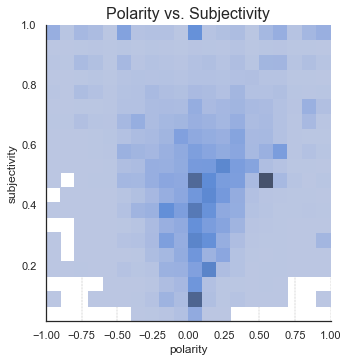

In [666]:
sns.displot(data=op, x='polarity', y='subjectivity', bins=20,log_scale=(False, False)) 
sns.set_style("whitegrid")
plt.title("Polarity vs. Subjectivity", size=16)
plt.grid(color='grey', linestyle='-.', linewidth=0.3);

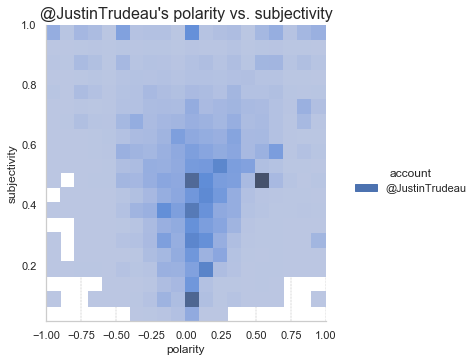

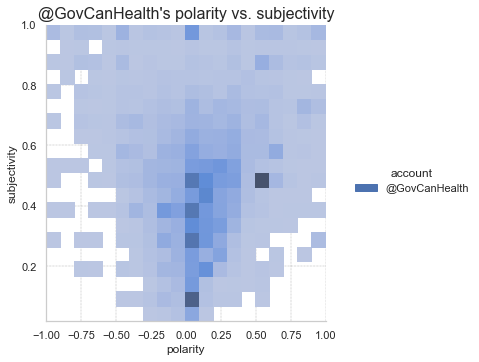

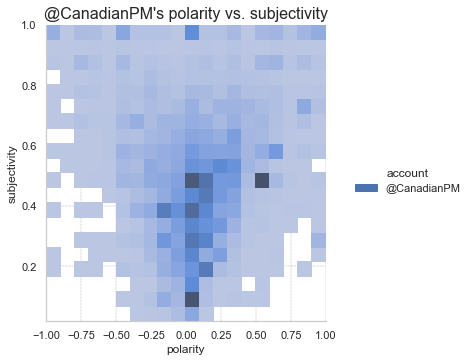

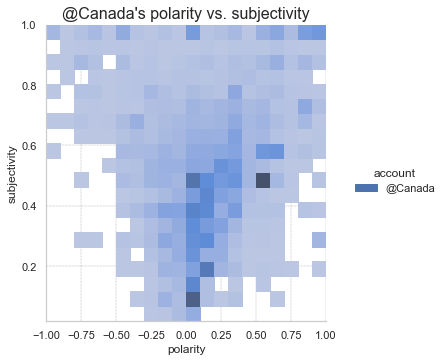

In [667]:
for acc in op.account.unique()[::-1].tolist():
    sns.set_style("whitegrid")
    sns.displot(data=op[op.account==acc], x='polarity', y='subjectivity', hue='account', bins=20,log_scale=(False, False)) 
    plt.title(acc + "'s polarity vs. subjectivity", size=16)
    plt.grid(color='grey', linestyle='-.', linewidth=0.3);

### Hypothesis testing sentiment on tweets

In the following table we can see the general statistics all tweets, dividing them in two groups: tweets published before Trudeau's annoucement, and tweets after the announcement.
#### Testing polarity

In [668]:
# Stats from the population of tweets
df.groupby(['announcement'])['polarity'].agg([pd.Series.count, np.mean, np.std]).reset_index()

announcement     count      mean       std
0        after  565400.0  0.074968  0.288586
1       before  214270.0  0.057588  0.288663

These two groups have more than 600 Thousand tweets, and in general any statistical test is going to be affected by a sample size this large.

So, in this case, we select a 1,000 sub-sample for each group -tweets before and after the announcement-, and use a t-test to compare the means between the two groups. 

$H_0:$ The mean polarity tweets published after Trudeau's annoucement is the same or lower than the mean polarity of tweets published before the announcement.  
$H_A:$ The mean polarity tweets published after Trudeau's annoucement is higher (with comments more positive) than the mean polarity of tweets published before the announcement.  
  
In other words:  
$H_0: \mu_{~after} \leq \mu_{~before}$  
$H_A: \mu_{~after} > \mu_{~before}$  

In [669]:
# select 1,000 tweets sample for each group, for polarity
np.random.seed(1)
df_polar_before = df[df.announcement == "before"].reset_index()[['polarity']].sample(1_000)
df_polar_after =  df[df.announcement ==  "after"].reset_index()[['polarity']].sample(1_000)

In [670]:
# hypothesis testing
ttest, pval = ttest_ind(df_polar_before, df_polar_after)
print("p-value", pval)

if pval < 0.05:
    print("We reject the null hypothesis")
else:
    print("We can't reject null hypothesis")

p-value [0.32817187]
We can't reject null hypothesis


> With a sub-sample of 1,000 tweets size, we can't reject the null hypothesis: the mean polarity of tweets published after Trudeau's annoucement is the same or lower than the mean polarity of tweets published before the announcement. This result is consistent with the descriptive analysis made in the previous sections.

#### Testing subjectivity

In [671]:
# Stats from the population of tweets
df.groupby(['announcement'])['subjectivity'].agg([pd.Series.count, np.mean, np.std]).reset_index()

announcement     count      mean       std
0        after  565400.0  0.377401  0.301471
1       before  214270.0  0.370309  0.307836

Similar to the hypothesis test done for polarity, we select a 1,000 sub-sample for each group -tweets before and after the announcement-, and use a t-test to compare the means between the two groups. 

$H_0:$ The mean subjectivity tweets published after Trudeau's annoucement is the same to the mean subjectivity of tweets published before the announcement.  
$H_A:$ The mean subjectivity tweets published after Trudeau's annoucement is different to the mean subjectivity of tweets published before the announcement.  
  
In other words:  
$H_0: \mu_{~after} = \mu_{~before}$  
$H_A: \mu_{~after} \neq \mu_{~before}$  

In [672]:
# select 1,000 tweets sample for each group, for subjectivity
np.random.seed(1)
df_polar_before = df[df.announcement == "before"].reset_index()[['subjectivity']].sample(1_000)
df_polar_after =  df[df.announcement ==  "after"].reset_index()[['subjectivity']].sample(1_000)

In [673]:
# hypothesis testing
ttest, pval = ttest_ind(df_polar_before, df_polar_after)
print("p-value", pval)

if pval < 0.05:
    print("We reject the null hypothesis")
else:
    print("We can't reject null hypothesis")

p-value [0.95203454]
We can't reject null hypothesis


> Similar to the polarity analysis, with a sub-sample of 1,000 tweets size, we can't reject the null hypothesis: the mean subjectivity tweets published after Trudeau's annoucement is the same to the mean subjectivity of tweets published before the announcement. This result is also consistent with the descriptive analysis made in the previous sections.

## Time Series

In [674]:
source = df.groupby(['account', 'day'])['tweet'].count().reset_index()

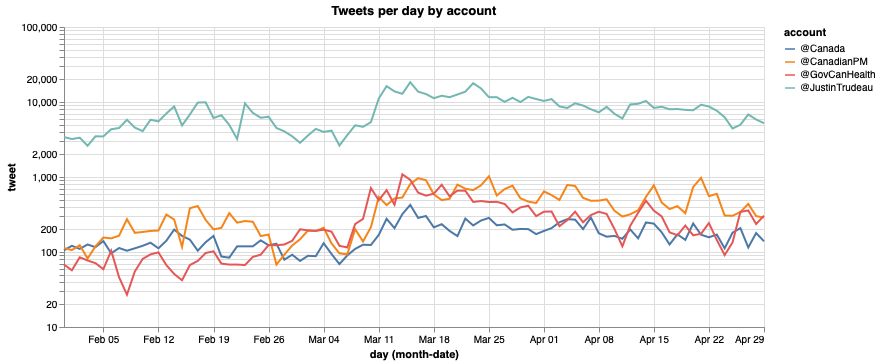

In [675]:
# Plot of tweets per day
alt.Chart(source).mark_line().encode(
    alt.X('monthdate(day):T'),
    alt.Y('tweet', scale=alt.Scale(type='log')),
    alt.Color('account')
).properties(
    title="Tweets per day by account",
    width=700
)

In [676]:
if type(df.day[0])==str:
    df.day = pd.to_datetime(df.day)

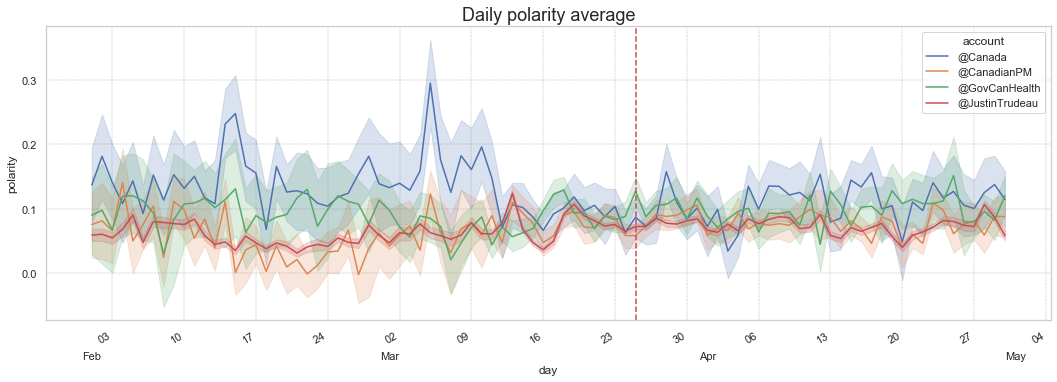

In [677]:
# Plot
fig, ax = plt.subplots()
sns.lineplot(x='day', y='polarity', hue='account', data=df, ax=ax)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b'))
ax.axvline('2020-03-25', color='r', linestyle='--')
fig.autofmt_xdate()
plt.title('Daily polarity average', size=18)
ax.set_facecolor('white')
plt.grid(color='gray', linestyle='-.', linewidth=0.3)
plt.show()

### ETS decomposition of polarity
Here we make an Error, Trend, Seasonality decomposition to check whether we have some trend or not.
First we quickly check out all of the accounts:

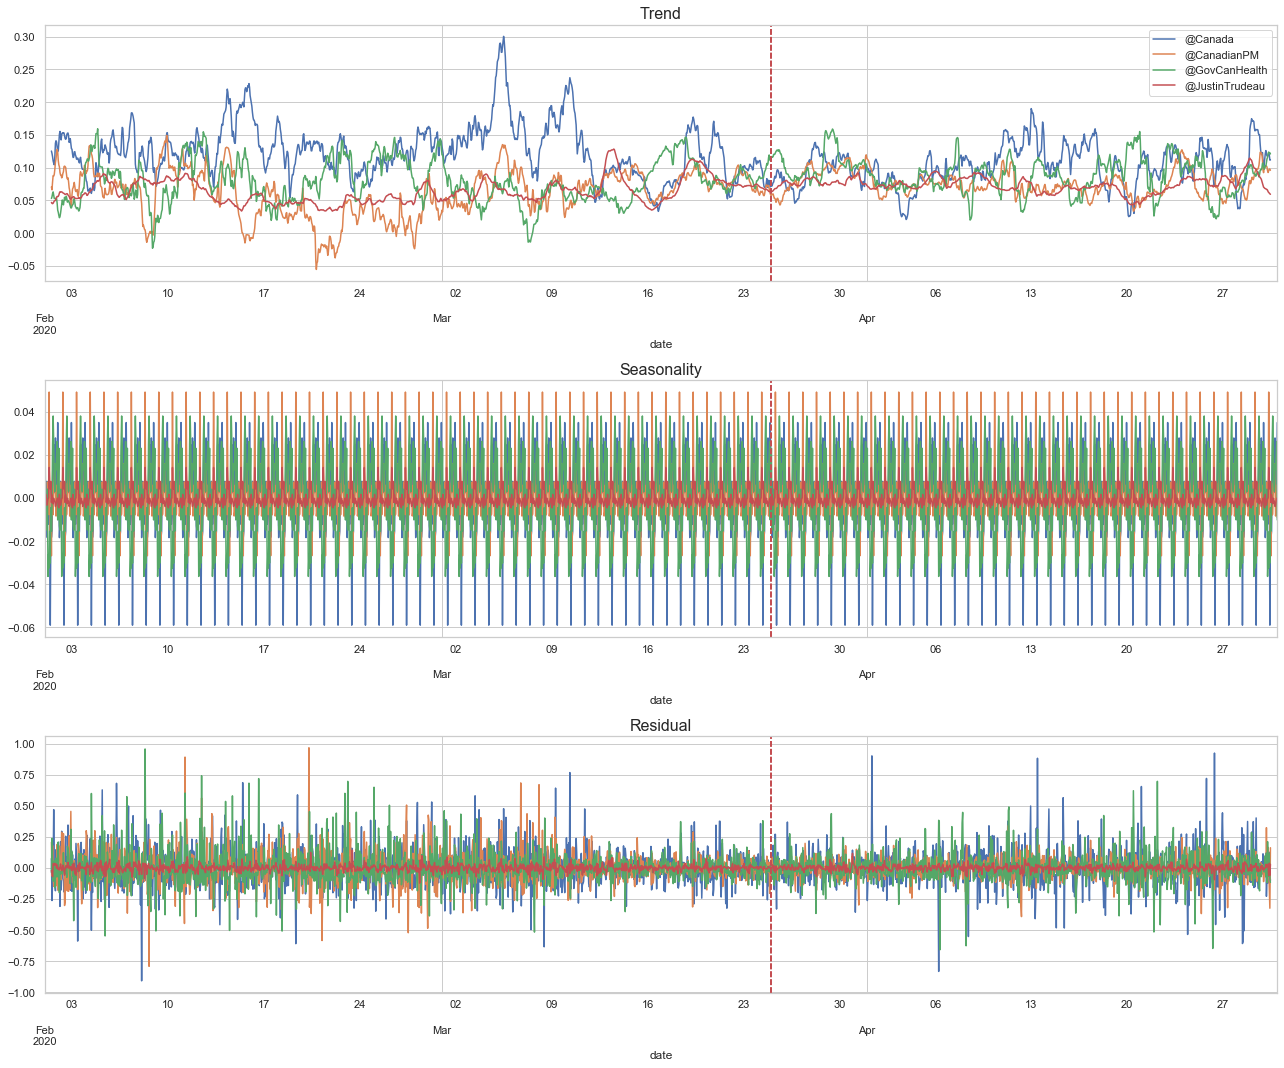

In [678]:
df_r=pd.DataFrame()
fig,ax = plt.subplots(3,1, sharex=False)
fig.set_figheight(15)
for i in df.account.unique():
    try:
        df_r = df.loc[df.account==i , ['polarity','date']].set_index('date').resample('H').mean().fillna(0)
    except ValueError:
        df_r = df.loc[df.account==i , ['polarity','date']].set_index('date').resample('D').mean().fillna(0)
    seasonal_decompose( df_r, model='additive').trend.plot(ax=ax[0], label=i);
    ax[0].set_title('Trend', size =16)
    ax[0].legend()
    ax[0].axvline('2020-03-25', color='r', linestyle='--')
    seasonal_decompose( df_r, model='additive').seasonal.plot(ax=ax[1], label=i);
    ax[1].set_title('Seasonality', size =16)
    ax[1].axvline('2020-03-25', color='r', linestyle='--')
    seasonal_decompose( df_r, model='additive').resid.plot(ax=ax[2], label=i);
    ax[2].set_title('Residual', size =16)
    ax[2].axvline('2020-03-25', color='r', linestyle='--')
plt.tight_layout();

Now, we focus on the trend only

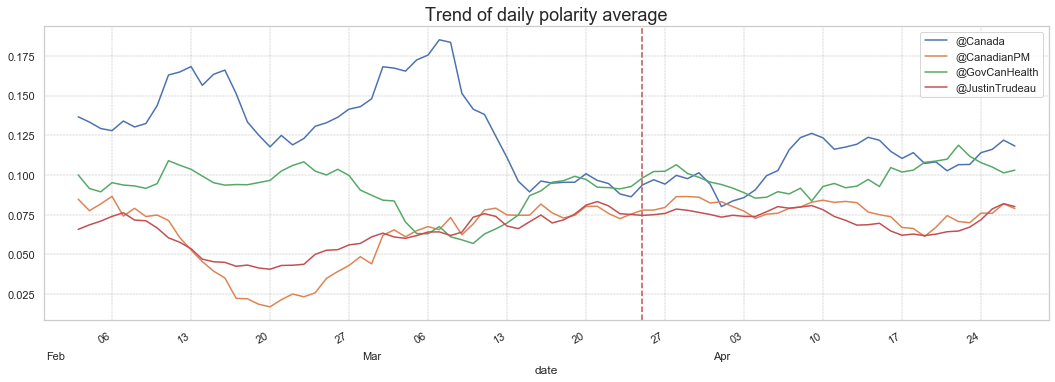

In [679]:
# Plot with trend  of daily polarity average
fig, ax = plt.subplots()
df_dic={}
for i in df.account.unique():
    try:
        df_r = df.loc[df.account==i , ['polarity','date']].set_index('date').resample('D').mean().fillna(0)
    except:
        pass
    df_dic[i] = seasonal_decompose( df_r, model='additive').trend
    df_dic[i].plot(ax=ax, label=i);

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b'))
ax.axvline(pd.to_datetime('2020-03-25'), color='r', linestyle='--')
ax.legend()
ax.yaxis.set_label('Daily polarity average')
fig.autofmt_xdate()
plt.title('Trend of daily polarity average', size=18)
ax.set_facecolor('white')
plt.grid(color='gray', linestyle='-.', linewidth=0.3)
plt.show()

This is interesting, it seems like right after the tweets there was a slight rise in the polarity levels. Although it seems that around the April 10th things went even better. **What happened here?**

For the time being, let's focus a little bit more on days that were closer to the 25th:

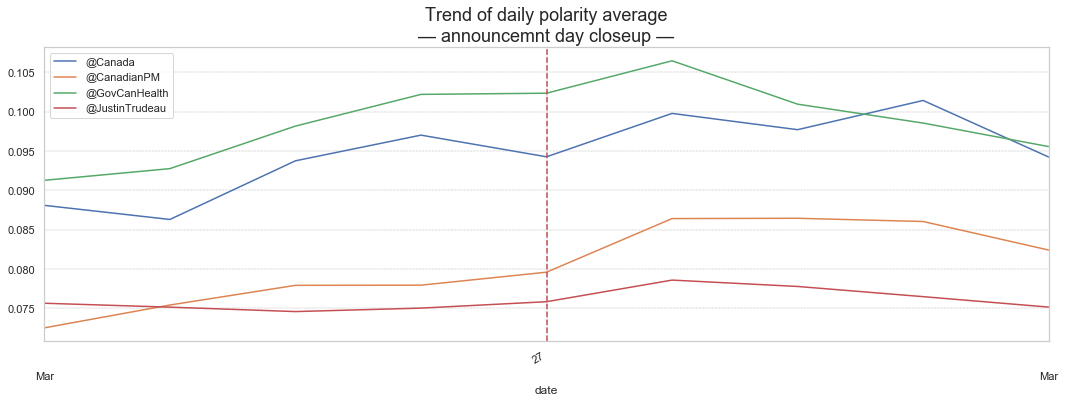

In [680]:
# Plot with trend of daily polarity average, with close up around Trudeau's annoucement
fig, ax = plt.subplots()
lower_bound='2020-03-22'
upper_bound='2020-04-01'
for i in df_dic.keys():
    df_dic[i][(df_dic[i].index>lower_bound)&(df_dic[i].index<upper_bound)].plot(ax=ax, label=i);

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b'))
ax.axvline(pd.to_datetime('2020-03-27'), color='r', linestyle='--')
ax.legend()
ax.yaxis.set_label('Daily polarity average')
fig.autofmt_xdate()
plt.title("Trend of daily polarity average\n— announcemnt day closeup —", size=18)
ax.set_facecolor('white')
plt.grid(color='gray', linestyle='-.', linewidth=0.3)
plt.show()

### Heatmap with Daily Polarity Average

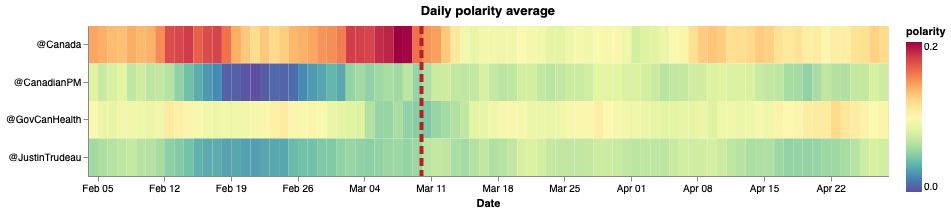

In [681]:
# Daily polarity average

# daily polarity DataFrame
df_2 = pd.DataFrame(pd.DataFrame(df_dic).dropna().stack()).reset_index().rename(columns={'level_1':'account', 0:'polarity'})
df_2.head()

#plot
# heatmap color
my_scheme=alt.Scale(
            scheme="spectral",
            reverse=True
)
# for more scheme colors go to https://vega.github.io/vega/docs/schemes/#reference

# heatmap with the daily polarity
base = alt.Chart(df_2).mark_rect().encode(
    x=alt.X('monthdate(date):T', title="Date"),
    y=alt.Y('account', title=""),
    color=alt.Color('polarity:Q', title="polarity", scale=my_scheme)
).properties(height=150, width=800)

# Line in the annoucement day: March 11th, 2020
rule = alt.Chart(pd.DataFrame({
    'day': ['2020-03-11'],
    'color': ['firebrick']
})).mark_rule(size=4, strokeDash=[8,4]).encode(
  x=alt.X('monthdate(day)'),
  color=alt.Color('color:N', title = "", scale=None)
)

(base + rule).properties(title='Daily polarity average')

Nice but the color code is still making us compare what people thought about *Canada* with what people thought about *Justin Trudeau*. 

Maybe we can actually make things more independent.

### Normalising so that every account has a minimum of 0 and a max of 1
This would help us seeing the polarity variations at first sight for each individual account

In [682]:
norm = pd.DataFrame(df_dic)[3:-3] - pd.DataFrame(df_dic)[3:-3].min(axis=0)
norm = norm.div( (pd.DataFrame(df_dic)[3:-3].max(axis=0)-pd.DataFrame(df_dic)[3:-3].min(axis=0)), axis=1)
norm.describe()

@Canada  @CanadianPM  @GovCanHealth  @JustinTrudeau
count  84.000000    84.000000      84.000000       84.000000
mean    0.409484     0.717152       0.581337        0.609547
std     0.249236     0.272406       0.210616        0.266643
min     0.000000     0.000000       0.000000        0.000000
25%     0.194246     0.651210       0.526302        0.492512
50%     0.385565     0.829072       0.604012        0.668906
75%     0.541696     0.892476       0.727991        0.809350
max     1.000000     1.000000       1.000000        1.000000

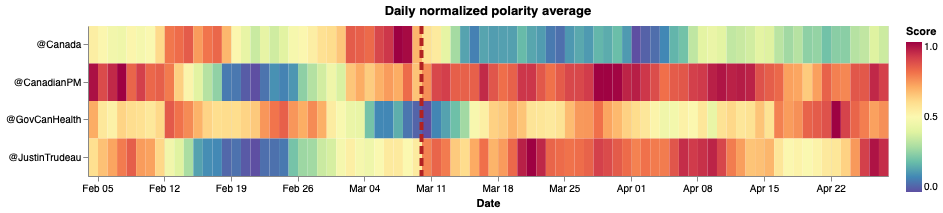

In [692]:
# Normalized daily polarity DataFrame

# get the DataFrame
df_2 = pd.DataFrame(norm.stack()).reset_index().rename(columns={'level_1':'account', 0:'polarity_norm'})

# heatmap with the daily polarity
base = alt.Chart(df_2).mark_rect().encode(
    x=alt.X('monthdate(date):T', title="Date"),
    y=alt.Y('account', title=""),
    color=alt.Color('polarity_norm:Q', title="Score", scale=my_scheme)  # Normalized polarity
).properties(height=150, width=800)

(base + rule).properties(title='Daily normalized polarity average') 

This is a bit of a but bumpy ride. Let's try to smoothen things out my plotting a moving average:

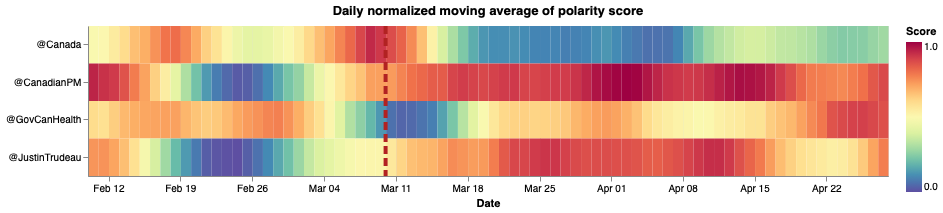

In [694]:
# Normalising the Moving Average of daily polarity

# get the DataFrame
df_2 = pd.DataFrame(norm.rolling(window=7).mean().dropna().stack()).reset_index()\
    .rename(columns={'level_1':'account', 0:'polarity_norm_MA'}) #polarity_norm_MA
df_2

# heatmap with the daily polarity
base = alt.Chart(df_2).mark_rect().encode(
    x=alt.X('monthdate(date):T', title="Date"),
    y=alt.Y('account', title=""),
    color=alt.Color('polarity_norm_MA:Q', title="Score", scale=my_scheme)  # Normalized MA polarity
).properties(height=150, width=800)

(base + rule).properties(title='Daily normalized moving average of polarity score') 

## Volume of tweets

### ETS decomposition

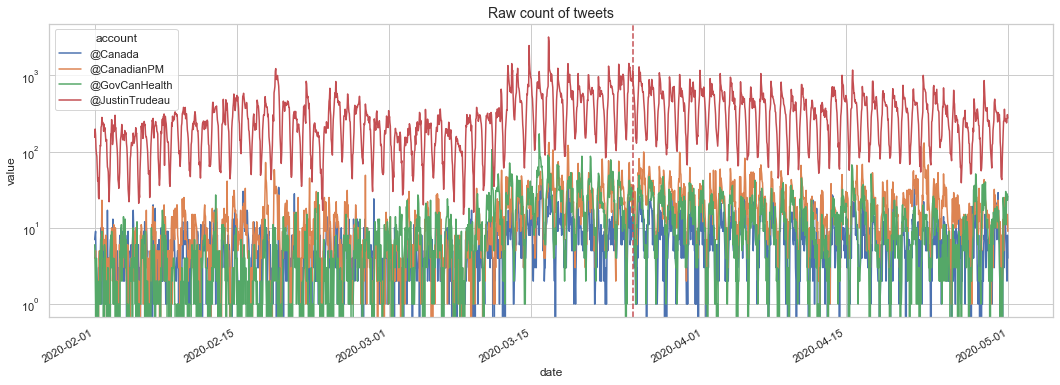

In [685]:
plt.rcParams["figure.figsize"] = (18,6)
# idx = pd.date_range(start=df.date.min(), end=df.date.max(), freq='D')

# Set the dataframe we will be using 
df1 = pd.DataFrame()
for i in df.account.unique().tolist():
    df1[i] = (df.loc[df.account==i , ['polarity','date']].set_index('date').resample('H').count().fillna(0)).polarity
df1 = df1.reset_index().melt(id_vars=['date'],var_name='account').set_index('date')

# Plot
fig, ax = plt.subplots()
sns.lineplot(x=df1.index, y='value', hue='account', data=df1, ax=ax)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set(yscale='log')
fig.autofmt_xdate()
ax.set_title('Raw count of tweets', size=14)
ax.axvline(pd.to_datetime('2020-03-25'), color='r', linestyle='--')

plt.show()

This is nice to see but it's still somewhat hard to understand the trend. If we decompose it like we've already done for polarity we might understand it better.

### Trend of tweet count

[None]

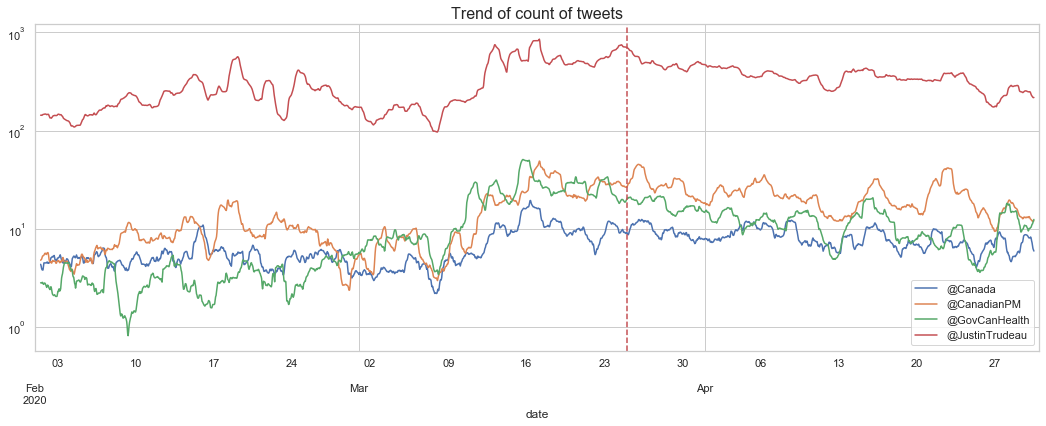

In [686]:
fig, ax = plt.subplots()

for acc in df.account.unique().tolist():
    seasonal_decompose(df1[df1.account==acc].value, model='additive').trend.plot(ax=ax);
plt.title('Trend of count of tweets', size = 16);
plt.legend(df.account.unique().tolist())
ax.axvline(pd.to_datetime('2020-03-25'), color='r', linestyle='--')
ax.set(yscale='log')

### Total volume of tweets

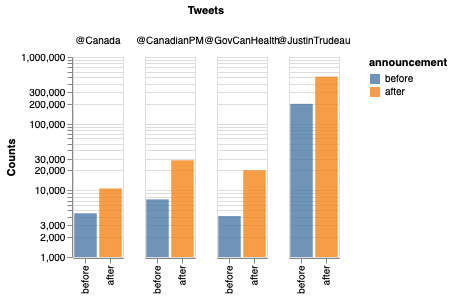

In [687]:
# plot volume of tweets 
df_volume = df.groupby(['account', 'announcement'])['tweet'].agg([pd.Series.count]).reset_index()
alt.Chart(df_volume, width=50, height=200).mark_bar(opacity=0.8).encode(
    x=alt.X('announcement', sort=['before', 'after'], title=""),
    y=alt.Y('count', title="Counts", scale=alt.Scale(type='log')), 
    color=alt.Color('announcement', sort=['before', 'after']),
    column=alt.Column('account', title="Tweets"),
    tooltip=['account', 'announcement', 'count']
)

> When comparing the volume of tweets published before and after, we can find that Trudeau's announcement had an impact in the number of tweets of users that mention any of the Canadian Government's account.

### Volume of actions and reactions: Reply, Retweet, Like and Quote

In [688]:
# dataframe with actions
df_volume = pd.DataFrame(df.groupby(['account', 'announcement'])\
                         ['replyCount', 'retweetCount', 'likeCount', 'quoteCount'].sum().stack())\
                         .reset_index().rename(columns = {'level_2':'type',0:'counts'})

In [689]:
def plot_volume(df, my_type='Reply'):
    """
    Funtion that uses altair to plot the volumen of a selected action 
    among: reply, retweet, like and quote.
    
    Parameters
    -------------
    df : (DataFrame)
        dataframe with three columns: twitter account, announcement, and a
        type of action.
    my_type : (str)
        type of action: reply, retweet, like and quote

    Returns
    -------------
    (plot) altair plot

    Example
    -------------
    plot_volume(df_volume, 'Like')
    """
    plot = alt.Chart(df[df.type == (my_type.lower()+"Count")], width=50, height=200).mark_bar(opacity=0.8).encode(
        x=alt.X('announcement', sort=['before', 'after'], title=""),
        y=alt.Y('counts', title="Counts", scale=alt.Scale(type='log')),
        color=alt.Color('announcement', sort=['before', 'after']),
        column=alt.Column('account', title=my_type)
    )
    return plot


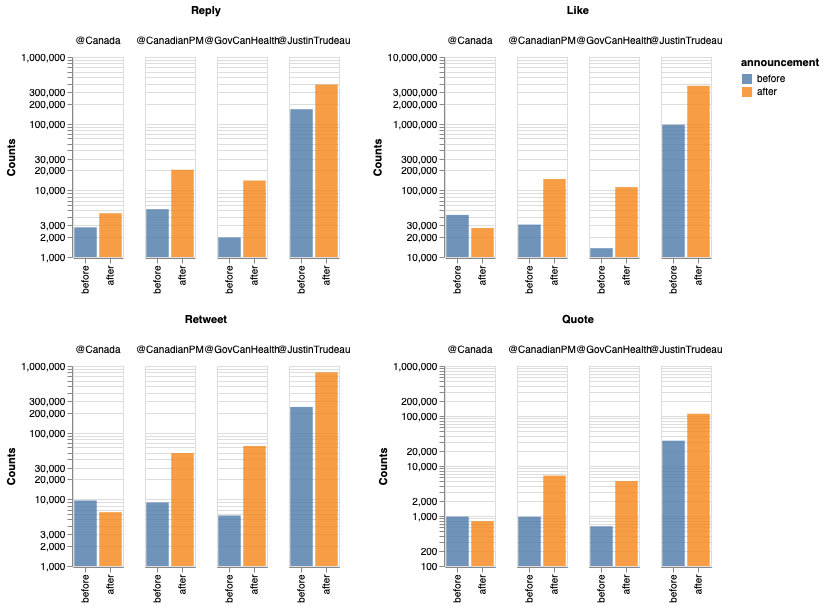

In [690]:
plot_1 = plot_volume(df_volume)
plot_2 = plot_volume(df_volume, 'Retweet')
plot_3 = plot_volume(df_volume, 'Like')
plot_4 = plot_volume(df_volume, 'Quote')

(plot_1 & plot_2) | (plot_3 & plot_4)

> Also, the annoucement had an impact in the actions and reactions of users, increasing the number of replies, likes, retweets and quotes when comparing this actions before and after the announcement.

## Final comments

The aim of this project was to compare the sentiment analysis of people before and after Trudeau's annoucement on March 27th, 2020, where the Canadian Government was willing to support small businesses and employees after Covid-19 finnancial impact.

To measure this impact we compare the polarity and subjectivity of tweets published before and after the annoucement mentioning Canadian Government's Twitter accounts ([@JustinTrudeau](https://twitter.com/JustinTrudeau?s=20), [@CanadianPM](https://twitter.com/CanadianPM), [@Canada](https://twitter.com/canada?lang=en) and [@GovCanHealth](https://twitter.com/govcanhealth?lang=en)).

While the sentiment analysis didn't show any difference on tweets sent before and after the announcement, it impact in the volume of tweets, actions and reactions of users as likes, replies, retweets and quotes.


In [691]:
print("Total time:", np.round((time.time() - START)/60, 2), "minutes.")

Total time: 2.48 minutes.
